<a href="https://colab.research.google.com/github/pachterlab/SBP_2019/blob/master/Example_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example analysis notebook - single cell studies database

This notebook produces figures in the manuscript `A curated database reveals trends in single cell transcriptomics`

Notebook repository: https://github.com/vals/single-cell-studies/

The database is available at: https://www.nxn.se/single-cell-studies/

Running this notebook will save the following figures in the current folder:
```
all_studies.pdf
biorxiv_over_time.pdf
cells_per_month.pdf
clustering_over_time.pdf
clusters_per_cells.pdf
pseudotime_over_time.pdf
scrnaseq_studies.pdf
studies_over_time.pdf
techniques_over_time.pdf
tsne_over_time.pdf
```

In [0]:
# %pylab inline
# %config InlineBackend.figure_format = 'retina'

import io

import matplotlib.font_manager
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# Only pandas >= v0.25.0 supports column names with spaces in querys
import pandas as pd
import plotnine as p
import requests
import numpy as np

import warnings
import matplotlib.colors as mplcol
import colorsys

warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's

In [0]:
url = "http://nxn.se/single-cell-studies/data.tsv"
df = pd.read_csv(url, sep='\t')
print(df.shape)

(729, 25)


In [0]:
# converts string to date format, can only be run once!
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# converts string of reported cells total to float, can only be run once!
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


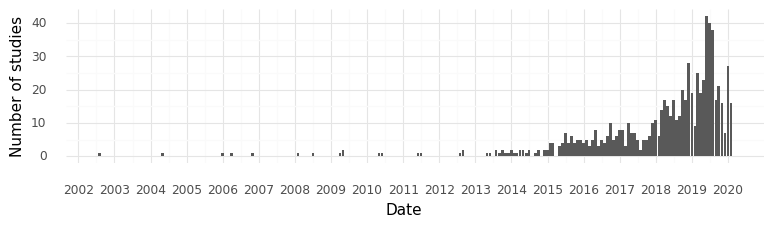

<ggplot: (-9223363263912146965)>


In [0]:
# plot number of studies over time
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI'), data=df.resample('1M', on='Date').count()[['DOI']].reset_index())
    + p.geom_bar(stat='identity')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies')
)
fig.save('studies_over_time.pdf')
print(fig)

In [0]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    
    return new_df

In [0]:
# alias for pd.Timestamp
ts = pd.Timestamp

In [0]:
#tdf is a temporary dataframe
tdf = tidy_split(df, 'Technique', ' & ')
# technique dictionary for top 5 techniques
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}

t_dict

{'Chromium': 'Chromium',
 'Drop-seq': 'Drop-seq',
 'InDrops': 'InDrops',
 'SMARTer (C1)': 'SMARTer (C1)',
 'Smart-seq2': 'Smart-seq2'}

In [0]:
# maps remaining tecnquines to `Other`
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))

In [0]:
# list of techniques in alphabetic order for the plot with `other` at the 
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

In [0]:
def desaturate(color, prop):
    """Decrease the saturation channel of a color by some percent.
    Parameters
    ----------
    color : matplotlib color
        hex, rgb-tuple, or html color name
    prop : float
        saturation channel of color will be multiplied by this value
    Returns
    -------
    new_color : rgb tuple
        desaturated color code in RGB tuple representation
    """
    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color


In [0]:
# lighten matplotlib default colors
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))
clrs

['#a7d2f0', '#ffc899', '#afe9af', '#efa8a9', '#ccb7e0', '#cccccc']

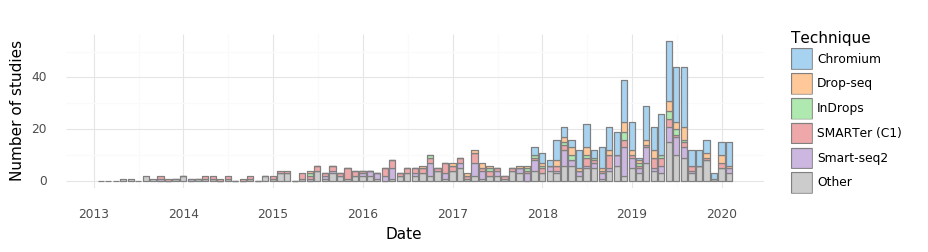

<ggplot: (-9223363263942730678)>

In [0]:
#### Plot number of studies per month by technique
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Technique'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)
fig.save('techniques_over_time.pdf')
fig

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


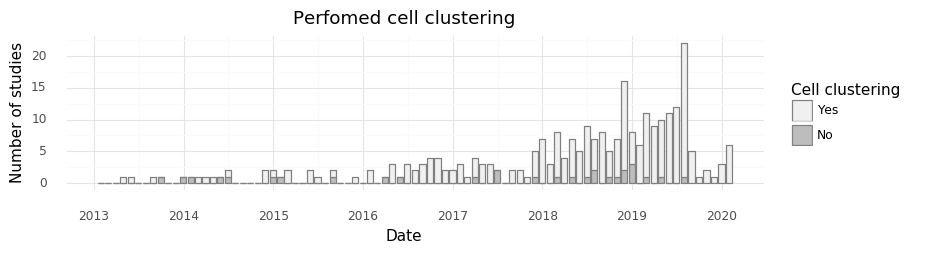

<ggplot: (8772911895016)>

In [0]:
# plot number of studies doing clustering over time

tdf = df[['Date', 'Cell clustering', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Cell clustering')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Cell clustering'] = (
    pd.Categorical(
        per_month['Cell clustering'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Cell clustering'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed cell clustering')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('clustering_over_time.pdf')
fig

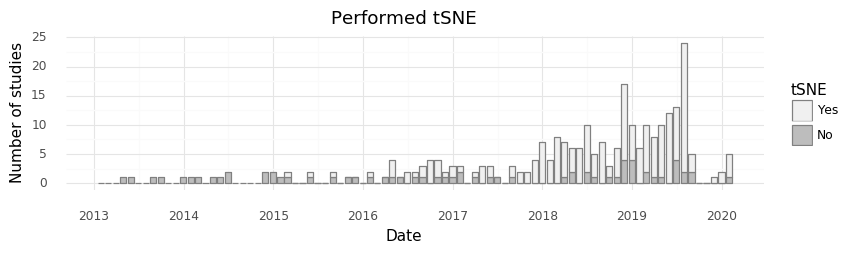

<ggplot: (-9223363263942731958)>

In [0]:
# plot number of studies using tsne over time

tdf = df[['Date', 'tSNE', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('tSNE')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['tSNE'] = (
    pd.Categorical(
        per_month['tSNE'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='tSNE'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Performed tSNE')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('tsne_over_time.pdf')
fig

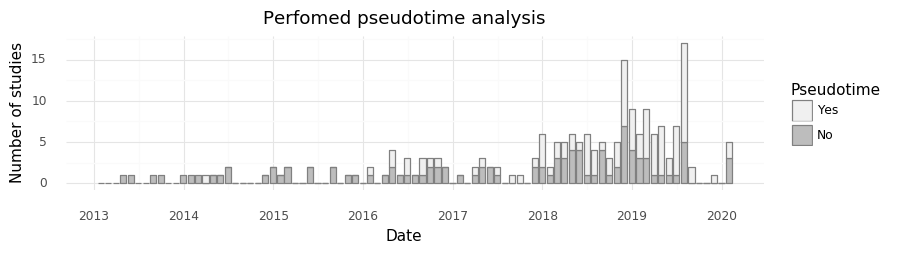

<ggplot: (8772911893077)>

In [0]:
#plot number of studies performing pseudoanalysis over time

tdf = df[['Date', 'Pseudotime', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Pseudotime')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Pseudotime'] = (
    pd.Categorical(
        per_month['Pseudotime'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='Pseudotime'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed pseudotime analysis')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('pseudotime_over_time.pdf')
fig

In [0]:
# uncomment the line below to print all authors and number of studies to easily search
# print(tdf['Authors'].value_counts().to_string())

In [0]:
# check top 20 authors
tdf = tidy_split(df, 'Authors', ', ')
tdf['Authors'].value_counts().head(20)

Aviv Regev                   52
Orit Rozenblatt-Rosen        22
Rahul Satija                 20
Sarah A. Teichmann           19
Fuchou Tang                  16
Sten Linnarsson              14
Danielle Dionne              14
Alex K. Shalek               13
John C. Marioni              13
Itay Tirosh                  12
Berthold Göttgens            12
Ido Amit                     11
Amit Zeisel                  11
Alexander van Oudenaarden    10
Karthik Shekhar              10
Cole Trapnell                10
Florent Ginhoux              10
Rickard Sandberg              9
Peter Lönnerberg              9
Dominic Grün                  9
Name: Authors, dtype: int64

In [0]:
# check total unique authors
np.unique(tdf['Authors']).shape[0]

7677

In [0]:
# check top 20 journals
df['Journal'].value_counts().head(20)

bioRxiv               116
Nature                 63
Cell                   61
Cell Reports           44
Science                43
Nat Commun             40
Genome Biol            20
Nat Methods            20
Cell Stem Cell         18
Nat Immunol            17
Immunity               16
Nat Biotechnol         16
Development            13
Nat Neurosci           12
Sci Rep                11
eLife                  11
Developmental Cell      9
J. Exp. Med.            9
Cell Systems            9
Cell Res                8
Name: Journal, dtype: int64

In [0]:
# check top 20 most common tissues
tdf = tidy_split(df, 'Tissue', ', ')
tdf['Tissue'].value_counts().head(20)

Brain             135
Culture            73
Blood              28
Embryo             21
Pancreas           20
Heart              18
Lung               16
Skin               15
Whole organism     14
Bone marrow        14
Tumor              12
Organoid           11
Testis             10
Kidney              9
Spleen              9
Breast              8
Eye                 7
Liver               7
Colon               7
Intestine           4
Name: Tissue, dtype: int64

In [0]:
# number of studies with preprints in the biorxiv
df['did_bioRxiv'] = (df['bioRxiv DOI'] != '-').map({True: 'Yes', False: 'No'})
print(df['did_bioRxiv'].value_counts())
cluster_fracs = df['did_bioRxiv'].value_counts()

print('Fraction of studies in biorxiv:', cluster_fracs['Yes'] / cluster_fracs.sum())

No     409
Yes    320
Name: did_bioRxiv, dtype: int64
Fraction of studies in biorxiv: 0.438957475994513


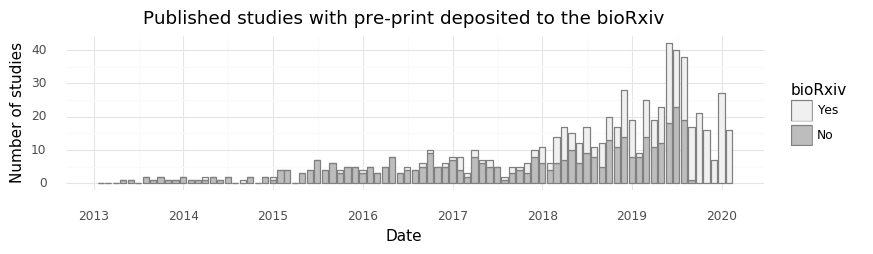

<ggplot: (8772911653864)>

In [0]:
# plot studies in the bioRxiv over time

tdf = df[['Date', 'did_bioRxiv', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('did_bioRxiv')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['did_bioRxiv'] = (
    pd.Categorical(
        per_month['did_bioRxiv'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='did_bioRxiv'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(
        y='Number of studies',
        title='Published studies with pre-print deposited to the bioRxiv',
        fill='bioRxiv'
    )
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('biorxiv_over_time.pdf')
fig

In [0]:
# display breakdown of deposited studies in biorXiv over the last 10 months 
display(
    per_month
    .pivot(index='Date', columns='did_bioRxiv', values='DOI')
    .fillna(0)
    .sort_index(ascending=False)
    .head(10)
)

did_bioRxiv,Yes,No
Date,,
2020-01-31,16.0,0.0
2019-12-31,27.0,0.0
2019-11-30,7.0,0.0
2019-10-31,16.0,0.0
2019-09-30,21.0,0.0
2019-08-31,16.0,1.0
2019-07-31,19.0,19.0
2019-06-30,17.0,23.0
2019-05-31,24.0,18.0


In [0]:
# check what kinds of measurements there are
df.Measurement.unique()

array(['qPCR', 'Microarray', 'RNA-seq', 'In Situ', 'RNA-seeq', nan,
       'RNA-seq & In Situ'], dtype=object)

In [0]:
# remove nan from measurement entries
df.Measurement = pd.Categorical(
    df.Measurement,
    categories=['RNA-seq', 'In Situ', 'Microarray'],
    ordered=True
)

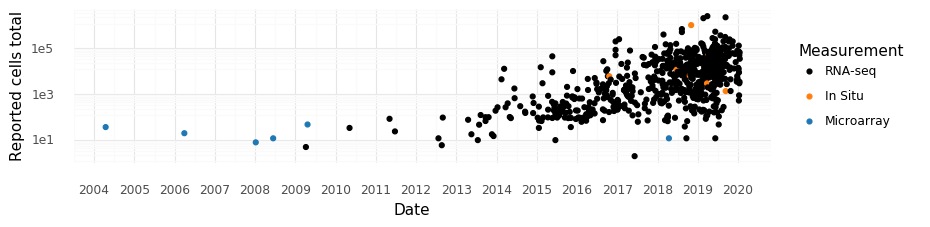

<ggplot: (-9223363263943157181)>

In [0]:
# plot kind of measurement over time vs number of cells reported
m_idx = df['Measurement'].value_counts().index

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes( x='Date', y='Reported cells total', color='Measurement'), 
        data=df.query('Measurement in @m_idx')
    )
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.scale_color_manual(['black', 'C1', 'C0'])
)
fig.save('all_studies.pdf')
fig

In [0]:
# make list of technologies
df['Tech'] = df['Technique'].map(lambda s: t_dict.get(s, 'Other'))

techs = list(
    df['Tech']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

df['Tech'] = (
    pd.Categorical(
       df['Tech'],
        categories=techs,
        ordered=True
    )
)

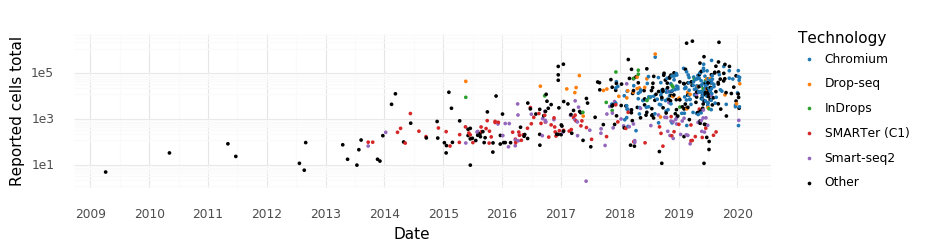

<ggplot: (8772911537889)>

In [0]:
# plot reported number of cells vs technology used over time
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='Reported cells total', fill='Tech'),
        data=df.query('Measurement == "RNA-seq"')
    )
    + p.geom_point(alpha=1, color='none', size=1)
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.scale_fill_manual(['C0', 'C1', 'C2', 'C3', 'C4', 'black'])
    + p.labs(fill='Technology')
)
fig.save('scrnaseq_studies.pdf')
fig

In [0]:
# display data for last 10 months 
display(
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')
    .median()
    .tail(10)
)

,Reported cells total,Number of reported cell types or clusters
Date,,
2019-04-30,15354.0,10.5
2019-05-31,15021.0,14.0
2019-06-30,15399.0,12.0
2019-07-31,14932.0,15.5
2019-08-31,15928.0,6.0
2019-09-30,40000.0,24.5
2019-10-31,46770.0,24.0
2019-11-30,95601.0,405.0
2019-12-31,6202.0,14.0


In [0]:
# display data for number of studies using RNA-seq for the last 10 months
display(
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')
    .count()
    .tail(10)[['DOI']]
)

,DOI
Date,
2019-04-30,22
2019-05-31,41
2019-06-30,40
2019-07-31,38
2019-08-31,17
2019-09-30,18
2019-10-31,14
2019-11-30,5
2019-12-31,21


In [0]:
# query number of cells reported in 2019
df.query('Measurement == "RNA-seq" and Date > @ts("20190101T010101")').median()

Reported cells total                         14585.0
Number of reported cell types or clusters       12.0
dtype: float64

In [0]:
# display median for last 8 months
df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().tail(8)

,Reported cells total,Number of reported cell types or clusters
Date,,
2019-06-30,15399.0,12.0
2019-07-31,14932.0,15.5
2019-08-31,15928.0,6.0
2019-09-30,40000.0,24.5
2019-10-31,46770.0,24.0
2019-11-30,95601.0,405.0
2019-12-31,6202.0,14.0
2020-01-31,13382.5,7.0


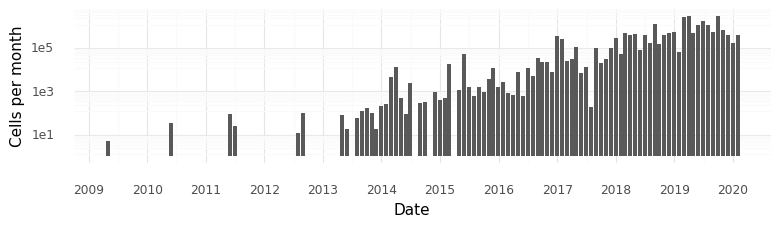

<ggplot: (8772911636477)>

In [0]:
# plot total number of cells in studies published each month over time
rna_df = df.query('Measurement == "RNA-seq"').resample('M', on='Date').sum().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=rna_df.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Cells per month')
)
fig.save('cells_per_month.pdf')
fig

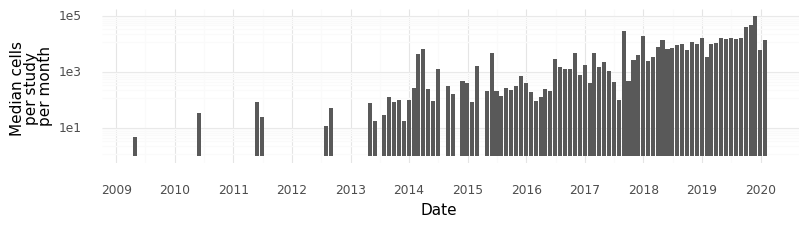

<ggplot: (-9223363263942793966)>

In [0]:
# plot median number of cells in studies each month
median_rna_df = df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=median_rna_df.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Median cells \nper study \nper month')
)
fig

In [0]:
#take a look at the last 5 entries in the dataset (newest studies)
df.tail().T

,724,725,726,727,728
Shorthand,Volden et al bioRxiv,Rubenstein et al SReports,Gillotay et al bioRxiv,Massoni-Badosa et al bioRxiv,Cho et al bioRxiv
DOI,10.1101/2020.01.10.902361,10.1038/s41598-019-57110-6,10.1101/2020.01.13.891630,10.1101/2020.01.15.897066,10.1101/2020.01.15.908350
Authors,"Roger Volden, Christopher Vollmers","Aliza B. Rubenstein, Gregory R. Smith, Ulrika ...","Pierre Gillotay, Meghna Shankar, Sema Elif Esk...","Ramon Massoni-Badosa, Giovanni Iacono, Catia M...","Bumsik Cho, Sang-Ho Yoon, Daewon Lee, Ferdinan..."
Journal,bioRxiv,Sci Rep,bioRxiv,bioRxiv,bioRxiv
Title,Highly Multiplexed Single-Cell Full-Length cDN...,Single-cell transcriptional profiles in human ...,Single-cell transcriptome analysis reveals cel...,Sampling artifacts in single-cell genomics coh...,Single-cell transcriptome maps of myeloid bloo...
Date,2020-01-12 00:00:00,2020-01-14 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00
bioRxiv DOI,10.1101/2020.01.10.902361,NaN,10.1101/2020.01.13.891630,10.1101/2020.01.15.897066,10.1101/2020.01.15.908350
Reported cells total,3000,3479,NaN,66136,35173
Organism,Human,"Human, Mouse",Zebrafish,Human,Drosophila
Tissue,Blood,Skeletal muscle,NaN,Blood,Lymph gland


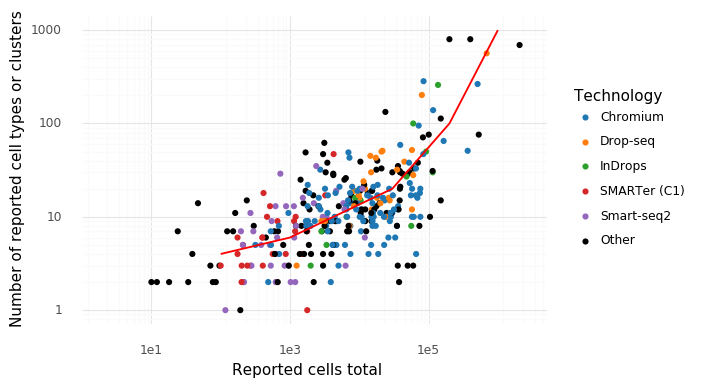

<ggplot: (8772912061658)>

In [0]:
# plot number of reported cell types/clusters vs total number of cells
# draw some arbitrary lines according to the orders of magnitude mentioned in the paper
reflines = pd.DataFrame(
    {
        'x': [1e2, 1e3, 3e4, 2e5, 1e6],
        'y': [4e0, 6e0, 2e1, 1e2, 1e3],
        'Tech': ['Other'] * 5
    }
)

p.options.figure_size = (6, 4)
fig = (
    p.ggplot(
        p.aes(
            x='Reported cells total',
            y='Number of reported cell types or clusters',
            fill='Tech'
        ),
        data=df.query('Measurement == "RNA-seq"')
    )
    + p.geom_point(alpha=1, color='none', size=2)
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_fill_manual(['C0', 'C1', 'C2', 'C3', 'C4', 'black'])
    + p.labs(fill='Technology')
    + p.geom_line(
        mapping=p.aes(x='x', y='y'),
        data=reflines,
        color='r',
        size=0.75
    )
)
fig.save('clusters_per_cells.pdf')
fig

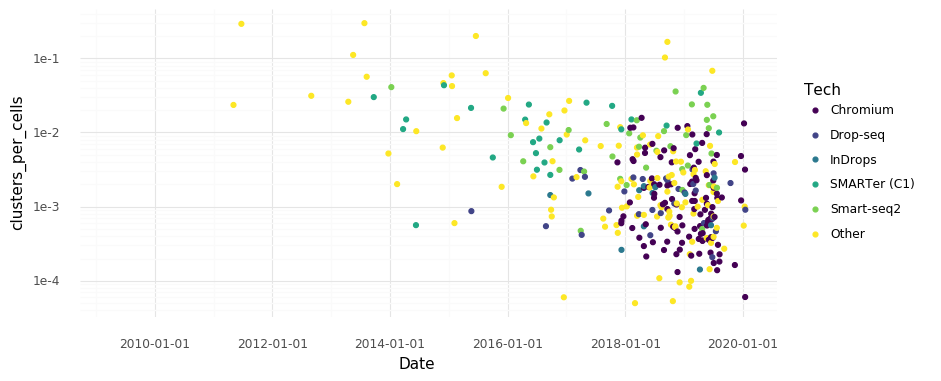

<ggplot: (8772911796025)>

In [0]:
# plot number of clusters vs technology over time
df['clusters_per_cells'] = df['Number of reported cell types or clusters'] / df['Reported cells total']

p.options.figure_size = (9, 4)
(
    p.ggplot(p.aes(x='Date', y='clusters_per_cells', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [0]:
# calculate number of authors in each study
df['num_authors'] = df['Authors'].str.split(',').str.len()

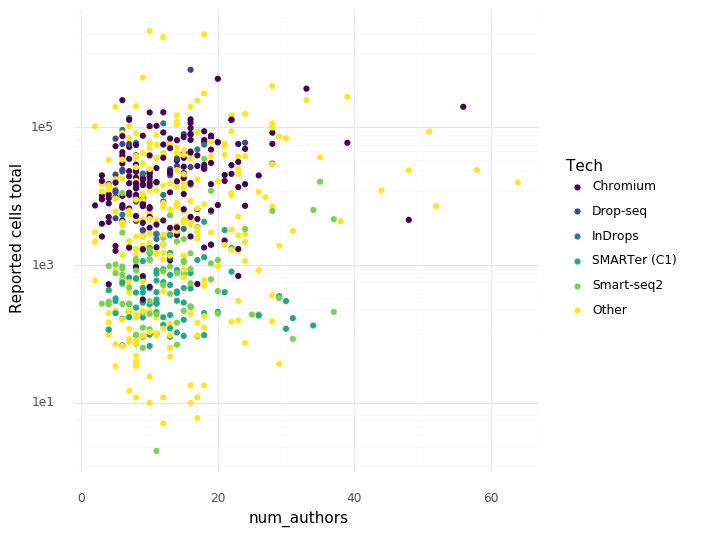

<ggplot: (-9223363263943330588)>

In [0]:
# plot total reported cells vs number of authors and technology
p.options.figure_size = (6, 6)
(
    p.ggplot(p.aes(x='num_authors', y='Reported cells total', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [0]:
# calculate number of cells reported per capita
df['cells_per_author'] = df['Reported cells total'] / df['num_authors']

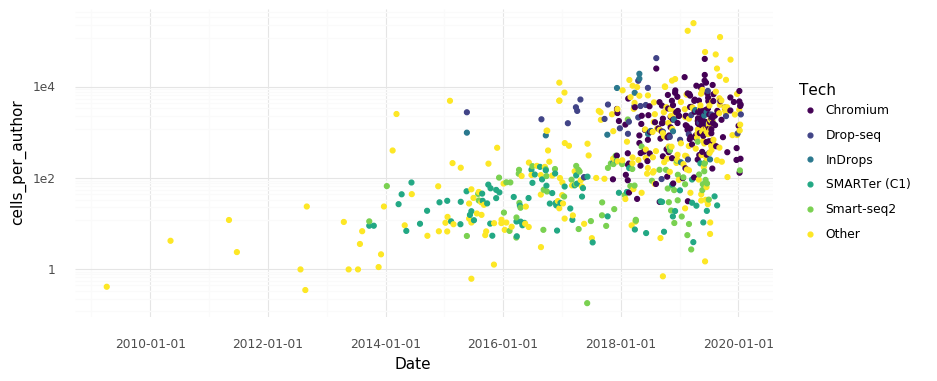

<ggplot: (8772911944070)>

In [0]:
# plot cells reported per capita
p.options.figure_size = (9, 4)
(
    p.ggplot(p.aes(x='Date', y='cells_per_author', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [0]:
# query dataframe for most recent studies doing tsne
df.query('tSNE == "Yes"').sort_values('Date').head()

,Shorthand,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Organism,Tissue,Technique,Data location,Panel size,Measurement,Cell source,Contrasts,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,did_bioRxiv,Tech,clusters_per_cells,num_authors,cells_per_author
50,Zeisel et al,10.1126/science.aaa1934,"A. Zeisel, A. B. Munoz-Manchado, S. Codeluppi,...",Science,Cell types in the mouse cortex and hippocampus...,2015-02-21,-,3005.0,Mouse,Brain,STRT-Seq (C1),GSE60361,NaN,RNA-seq,"Somatosensory cortex, hippocampus CA1",NaN,Adult,47.0,Yes,No,NaN,Yes,Yes,NaN,IFC Capture,No,Other,0.015641,14,214.642857
57,Macosco et al Cell,10.1016/j.cell.2015.05.002,"Evan Z. Macosko, Anindita Basu, Rahul Satija, ...",Cell,Highly Parallel Genome-wide Expression Profili...,2015-05-21,-,44808.0,"Human, Mouse",Eye,Drop-seq,GSE63473,NaN,RNA-seq,Retina,NaN,NaN,39.0,Yes,No,No,Yes,Yes,NaN,Nanodroplet dilution,No,Drop-seq,0.000870,16,2800.500000
72,Grun et al Nature,10.1038/nature14966,"Dominic Grün, Anna Lyubimova, Lennart Kester, ...",Nature,Single-cell messenger RNA sequencing reveals r...,2015-08-18,-,238.0,Mouse,Organoid,CEL-seq,GSE62270,NaN,RNA-seq,Intestinal organoids,NaN,NaN,15.0,Yes,No,No,No,Yes,NaN,NaN,No,Other,0.063025,8,29.750000
98,Macaulay et al CReports,10.1016/j.celrep.2015.12.082,"Iain C. Macaulay, Valentine Svensson, Charlott...",Cell Reports,Single-Cell RNA-Sequencing Reveals a Continuou...,2016-01-21,-,652.0,Zebrafish,"Kidney, Heart",Smart-seq2,E-MTAB-3947,NaN,RNA-seq,cd41 cells from kidney and heart,NaN,NaN,6.0,Yes,Yes,No,No,Yes,NaN,NaN,No,Smart-seq2,0.009202,8,81.500000
107,Tirosh et al Science,10.1126/science.aad0501,"I. Tirosh, B. Izar, S. M. Prakadan, M. H. Wads...",Science,Dissecting the multicellular ecosystem of meta...,2016-04-07,-,4645.0,Human,NaN,Smart-seq2,GSE72056,NaN,RNA-seq,Melanoma,NaN,NaN,19.0,Yes,No,No,Yes,Yes,NaN,Sorting (FACS),No,Smart-seq2,0.004090,37,125.540541


In [0]:
# query dataframe for most recent studies doing pseudotime
df.query('Pseudotime == "Yes"').sort_values('Date').head()

,Shorthand,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Organism,Tissue,Technique,Data location,Panel size,Measurement,Cell source,Contrasts,Developmental stage,Number of reported cell types or clusters,Cell clustering,Pseudotime,RNA Velocity,PCA,tSNE,H5AD location,Isolation,did_bioRxiv,Tech,clusters_per_cells,num_authors,cells_per_author
31,Trapnell et al NBT,10.1038/nbt.2859,"Cole Trapnell, Davide Cacchiarelli, Jonna Grim...",Nat Biotechnol,The dynamics and regulators of cell fate decis...,2014-03-23,-,270.0,Human,NaN,SMARTer (C1),GSE52529,NaN,RNA-seq,Primary myoblasts,NaN,NaN,3.0,Yes,Yes,No,NaN,NaN,NaN,IFC Capture,No,SMARTer (C1),0.011111,10,27.000000
98,Macaulay et al CReports,10.1016/j.celrep.2015.12.082,"Iain C. Macaulay, Valentine Svensson, Charlott...",Cell Reports,Single-Cell RNA-Sequencing Reveals a Continuou...,2016-01-21,-,652.0,Zebrafish,"Kidney, Heart",Smart-seq2,E-MTAB-3947,NaN,RNA-seq,cd41 cells from kidney and heart,NaN,NaN,6.0,Yes,Yes,No,No,Yes,NaN,NaN,No,Smart-seq2,0.009202,8,81.500000
108,Petropoulos et al Cell,10.1016/j.cell.2016.03.023,"Sophie Petropoulos, Daniel Edsgärd, Björn Rein...",Cell,Single-Cell RNA-Seq Reveals Lineage and X Chro...,2016-04-09,-,1529.0,Human,Embryo,Smart-seq2,E-MTAB-3929,NaN,RNA-seq,Preimplantation embryos,NaN,NaN,NaN,NaN,Yes,No,Yes,Yes,NaN,NaN,No,Smart-seq2,NaN,10,152.900000
112,Lacar et al NCommunications,10.1038/ncomms11022,"Benjamin Lacar, Sara B. Linker, Baptiste N. Ja...",Nat Commun,Nuclear RNA-seq of single neurons reveals mole...,2016-04-19,-,201.0,Mouse,Brain,SMARTer (C1),GSE77067,NaN,RNA-seq,"Neurons, dentate granule",NaN,NaN,3.0,Yes,Yes,No,Yes,No,NaN,NaN,No,SMARTer (C1),0.014925,18,11.166667
118,Treutlein et al Nature,10.1038/nature18323,"Barbara Treutlein, Qian Yi Lee, J. Gray Camp, ...",Nature,Dissecting direct reprogramming from fibroblas...,2016-06-07,-,405.0,Mouse,Embryo,SMARTer (C1),GSE67310,NaN,RNA-seq,Embryonic fibroblasts,NaN,NaN,3.0,Yes,Yes,No,Yes,Yes,NaN,NaN,No,SMARTer (C1),0.007407,11,36.818182
